In [1]:
import os
import pickle

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
from tqdm.auto import tqdm

import multitask.dataset as dataset
import multitask.models.parallel.hooks as hooks
from multitask.models.parallel.models import get_parallel_model
from multitask.representations import get_mean_activations, calculate_rdm, plot_rdm
from multitask.utils.training import get_device
from multitask.utils.argparse import check_runs

In [2]:
sns.set_theme(style='ticks', palette='pastel')
mpl.rcParams['font.family'] = 'Liberation Sans'

In [3]:
path_data = os.path.join('..', '..', 'data')
path_figure = os.path.join('svg', 'figure02a_rdm_parallel.svg')
path_model_parallel = os.path.join('..', '..', 'results', 'parallel')
path_pickle = os.path.join('pickle', 'rdm_parallel.pickle')

## RDM Parallel

In [4]:
num_runs = 10
initial_seed = 6789
max_seed = 10e5
num_epochs = 50
num_hidden = 5 * [100]
batch_size = 100
num_train = 50000
num_test = 10000
tasks_names = ['parity', 'value']

In [5]:
parameters = {
    'num_runs': num_runs,
    'initial_seed': initial_seed,
    'max_seed': max_seed,
    'num_epochs': num_epochs,
    'num_hidden': num_hidden,
    'batch_size': batch_size,
    'num_train': num_train,
    'num_test': num_test,
    'tasks': tasks_names,
    'idxs_contexts': None
}

data_folder = check_runs(path_model_parallel, parameters)

Found simulation in ../../results/parallel with the same parameters (2022-09-27_23_18_55)


In [6]:
pickle_data = os.path.join(data_folder, 'data.pickle')
with open(pickle_data, 'rb') as handle:
    results_parallel = pickle.load(handle)

In [7]:
seeds = sorted(list(results_parallel.keys()))
num_seeds = len(seeds)
num_tasks = len(tasks_names)

print(seeds)
print(tasks_names)

[10612, 17350, 130146, 173249, 213794, 341996, 440064, 668870, 858781, 894813]
['parity', 'value']


In [8]:
tasks_datasets = dataset.get_tasks_dict(tasks_names, root=path_data)

In [9]:
parallel_datasets = {}
for task_name in tasks_names:
    parallel_datasets[task_name] = tasks_datasets[task_name]

parallel_tasks = dataset.MultilabelTasks(parallel_datasets)

## Plot All RDMs

Running on CPU.


  0%|          | 0/10 [00:00<?, ?it/s]

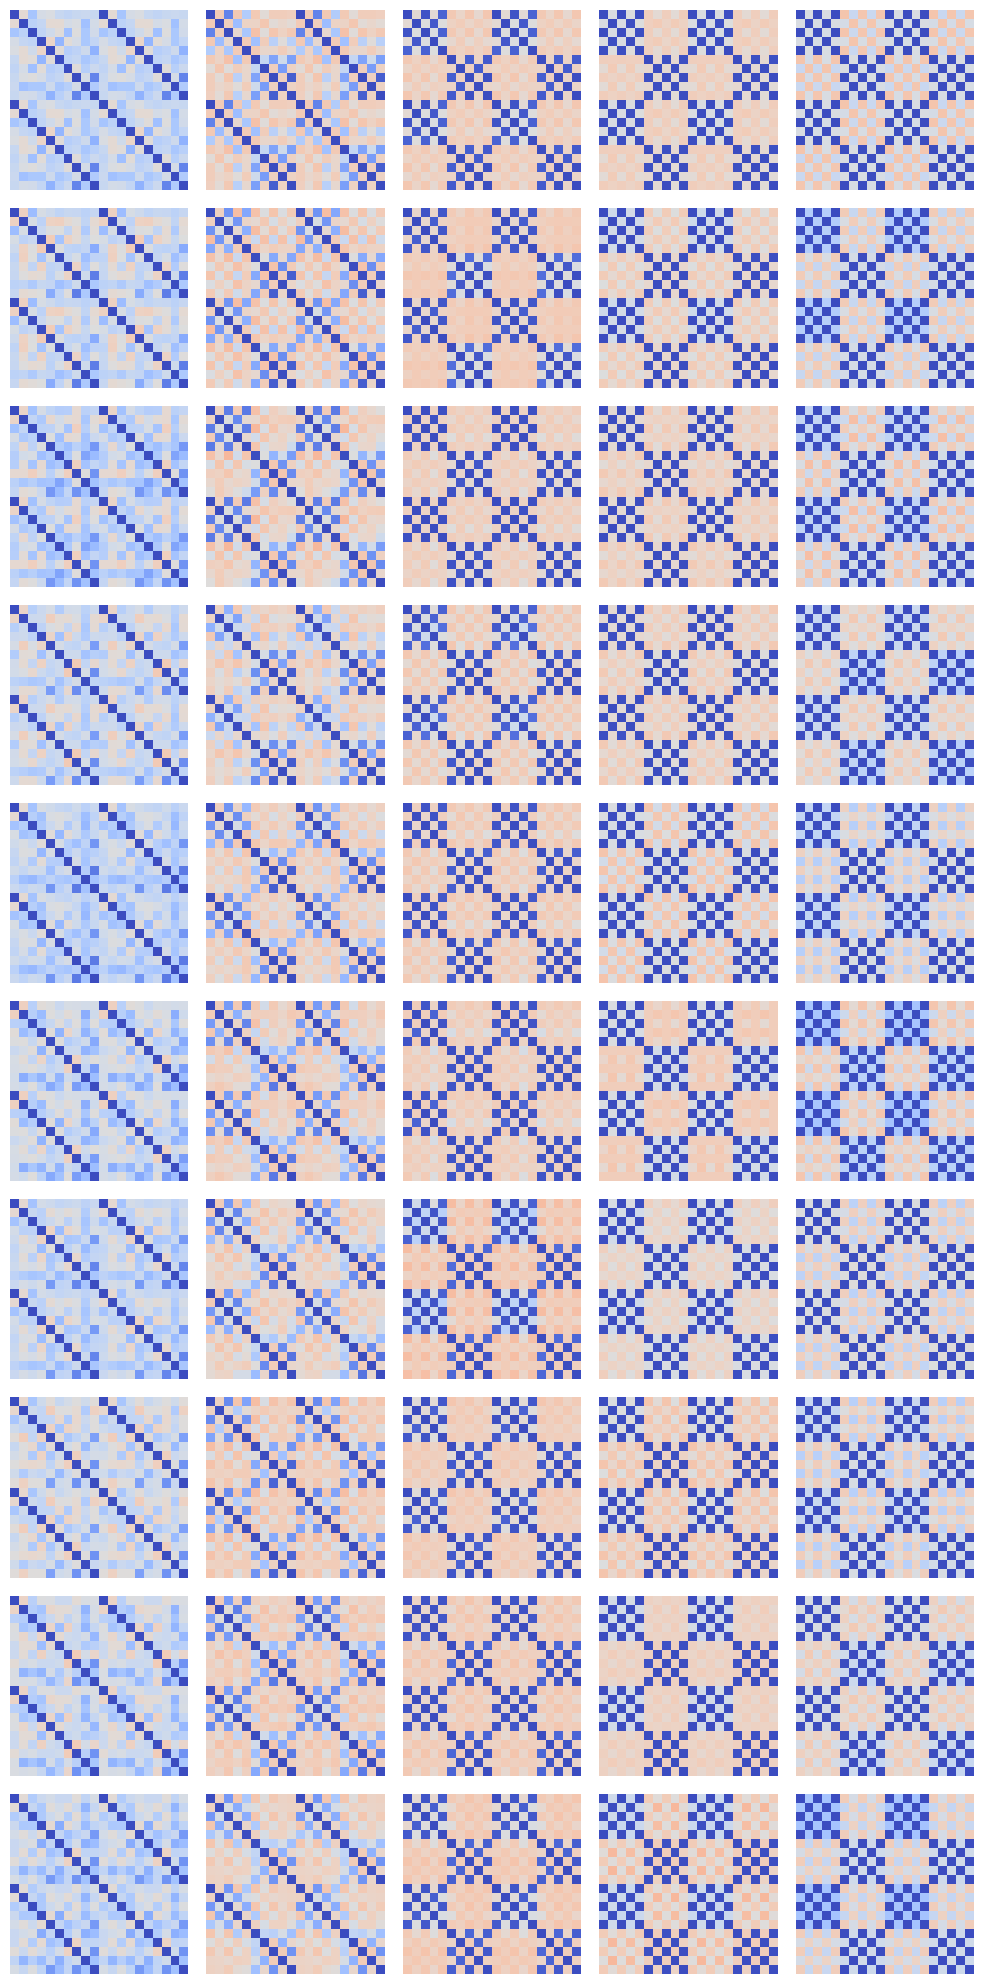

In [10]:
device = get_device()
criterion = nn.CrossEntropyLoss()
num_layers = len(num_hidden)
num_tasks = len(tasks_names)
list_rdm = []

fig, ax = plt.subplots(num_runs, num_layers, figsize=(2 * num_layers, 2 * num_runs))

for i_seed, seed in tqdm(enumerate(seeds), total=num_runs):
    state_dict = results_parallel[seed]['model']
    model = get_parallel_model(num_tasks,
                               num_hidden,
                               device)

    model.load_state_dict(state_dict)
    
    indices = results_parallel[seed]['indices']

    test_sampler = dataset.SequentialSampler(indices['test'])
    parallel_testloader = torch.utils.data.DataLoader(parallel_tasks,
                                                      sampler=test_sampler,
                                                      batch_size=batch_size)

    numbers = parallel_datasets[tasks_names[0]].numbers.numpy()
    numbers = numbers[indices['test']]
    
    _, activations = hooks.get_layer_activations(model,
                                                 parallel_testloader,
                                                 criterion=criterion,
                                                 device=device,
                                                 disable=True)
    
    task_activations = []
    task_numbers = []
    
    for task_name in tasks_names:
        task_activations.append(activations)
        task_numbers.append(numbers)

    mean_activations = get_mean_activations(task_activations,
                                            num_hidden,
                                            list_labels=task_numbers,
                                            tasks_names=tasks_names)

    rdm_dict = calculate_rdm(mean_activations,
                             tasks_names=tasks_names)


    list_rdm.append(rdm_dict)

    plot_rdm(ax[i_seed], rdm_dict, num_hidden, cmap='coolwarm', vmin=0, vmax=1)

fig.tight_layout()
plt.show()

In [11]:
parent_pickle = os.path.dirname(path_pickle)

if not os.path.exists(parent_pickle):
    os.makedirs(parent_pickle)

with open(path_pickle, 'wb') as f:
    pickle.dump(list_rdm, f, protocol=pickle.HIGHEST_PROTOCOL)

## Average RDM

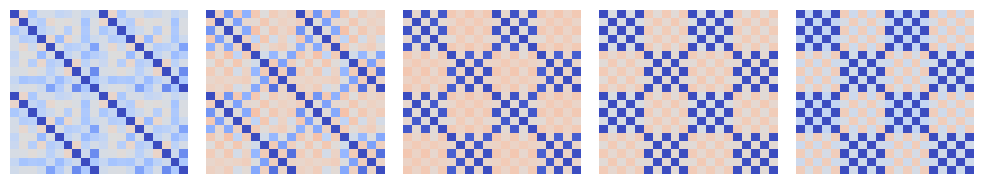

In [12]:
mean_rdm = {}

for layer in range(num_layers):
    mean_rdm[layer+1] = np.zeros((num_tasks * 10, num_tasks * 10))
    for rdm in list_rdm:
        mean_rdm[layer+1] += rdm[layer+1]
    mean_rdm[layer+1] /= num_runs

fig, ax = plt.subplots(1, num_layers, figsize=(2 * num_layers, 2))
plot_rdm(ax, mean_rdm, num_hidden, cmap='coolwarm', vmin=0, vmax=1)
fig.tight_layout()
fig.savefig(path_figure)
plt.show()

## Plot Single RDM

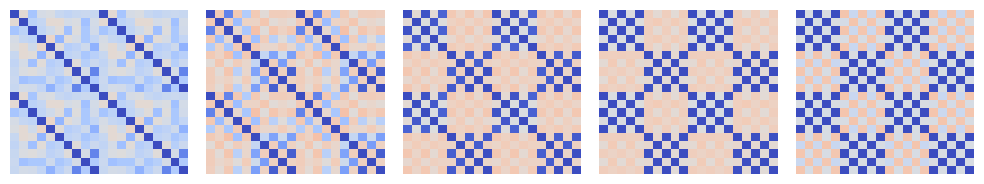

In [13]:
idx_seed = 0
seed = seeds[idx_seed]

state_dict = results_parallel[seed]['model']
model = get_parallel_model(num_tasks,
                           num_hidden,
                           device)

model.load_state_dict(state_dict)

indices = results_parallel[seed]['indices']

test_sampler = dataset.SequentialSampler(indices['test'])
parallel_testloader = torch.utils.data.DataLoader(parallel_tasks,
                                                    sampler=test_sampler,
                                                    batch_size=batch_size)

numbers = parallel_datasets[tasks_names[0]].numbers.numpy()
numbers = numbers[indices['test']]

_, activations = hooks.get_layer_activations(model,
                                             parallel_testloader,
                                             criterion=criterion,
                                             device=device,
                                             disable=True)

task_activations = []
task_numbers = []

for task_name in tasks_names:
    task_activations.append(activations)
    task_numbers.append(numbers)

mean_activations = get_mean_activations(task_activations,
                                        num_hidden,
                                        list_labels=task_numbers,
                                        tasks_names=tasks_names)

rdm_dict = calculate_rdm(mean_activations,
                         tasks_names=tasks_names)

fig, ax = plt.subplots(1, num_layers, figsize=(2 * num_layers, 2))
plot_rdm(ax, rdm_dict, num_hidden, cmap='coolwarm', vmin=0, vmax=1)
fig.tight_layout()
plt.show()